In [1]:
# ✅ Colab setup: compatible with TensorFlow 2.19+
!pip install -q tensorflow keras opencv-python-headless matplotlib scikit-learn seaborn ultralytics

import tensorflow as tf
print("✅ TensorFlow version:", tf.__version__)
print("✅ GPU available:", tf.config.list_physical_devices('GPU'))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.7 MB/s eta 0:00:00
✅ TensorFlow version: 2.19.0
✅ GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Example: assume datasets unzipped in /content/drive/MyDrive/aerial_project/
BASE_PATH = "/content/drive/MyDrive/aerial_project"  # adjust to your folder
# Ensure you have:
# BASE_PATH/classification_dataset/TRAIN/bird, /TRAIN/drone, /VALID/, /TEST/

Mounted at /content/drive


Image counts: {'train/bird': 1414, 'train/drone': 1248, 'valid/drone': 225, 'valid/bird': 217, 'test/drone': 94, 'test/bird': 121}


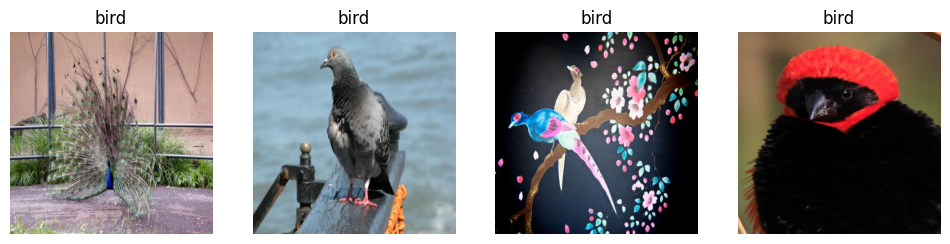

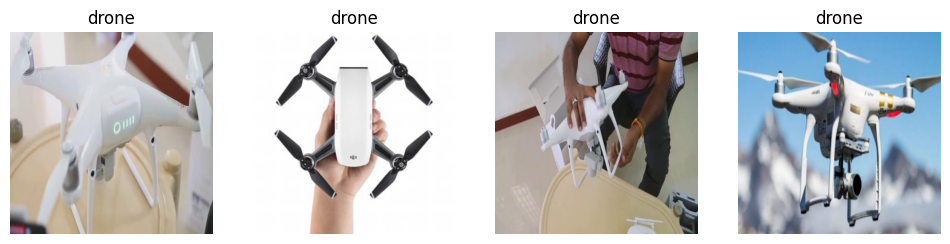

In [7]:
import os
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import random
import cv2

def count_images(base_path):
    counts = {}
    for split in ["train", "valid", "test"]:
        split_path = Path(base_path) / "classification_dataset" / split
        if not split_path.exists():
            continue
        for cls in os.listdir(split_path):
            cls_path = split_path / cls
            counts[f"{split}/{cls}"] = len(list(cls_path.glob("*.jpg")))
    return counts

counts = count_images(BASE_PATH)
print("Image counts:", counts)

# show a few samples
def show_samples(base_path, split="train", cls="bird", n=4):
    folder = Path(base_path) / "classification_dataset" / split / cls
    imgs = list(folder.glob("*.jpg"))
    imgs = random.sample(imgs, min(n, len(imgs)))
    plt.figure(figsize=(12,4))
    for i,p in enumerate(imgs):
        img = cv2.imread(str(p))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,n,i+1); plt.imshow(img); plt.axis('off'); plt.title(cls)
    plt.show()

show_samples(BASE_PATH, "train", "bird", 4)
show_samples(BASE_PATH, "train", "drone", 4)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
seed = 42

train_dir = os.path.join(BASE_PATH, "classification_dataset", "train")
val_dir   = os.path.join(BASE_PATH, "classification_dataset", "valid")
test_dir  = os.path.join(BASE_PATH, "classification_dataset", "test")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # (augmentations optional)
    # rotation_range=10, width_shift_range=0.05, height_shift_range=0.05,
    # horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,         # <- 224x224
    color_mode='rgb',             # <- force RGB
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=seed
)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,         # <- 224x224
    color_mode='rgb',             # <- force RGB
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
test_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,         # <- 224x224
    color_mode='rgb',             # <- force RGB
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Class indices: {'bird': 0, 'drone': 1}


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_custom_cnn(input_shape=(224,224,3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

custom_model = build_custom_cnn((IMG_SIZE[0], IMG_SIZE[1], 3))
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
custom_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,297 (434.75 KB)

 Trainable params: 110,593 (432.00 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

epochs = 30
checkpoint_path = "/content/custom_cnn_best.h5"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = custom_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6680 - loss: 0.6978

84/84 ━━━━━━━━━━━━━━━━━━━━ 1053s 12s/step - accuracy: 0.6681 - loss: 0.6975 - val_accuracy: 0.6244 - val_loss: 0.6801 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.7050 - loss: 0.5810

84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 560ms/step - accuracy: 0.7051 - loss: 0.5810 - val_accuracy: 0.6765 - val_loss: 0.6329 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.7546 - loss: 0.5314

84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 575ms/step - accuracy: 0.7545 - loss: 0.5316 - val_accuracy: 0.6652 - val_loss: 0.6056 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.7465 - loss: 0.5389

84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 570ms/step - accuracy: 0.7465 - loss: 0.5389 - val_accuracy: 0.6787 - val_loss: 0.5720 - learning_rate: 0.0010
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.7612 - loss: 0.5142

84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 569ms/step - accuracy: 0.7613 - loss: 0.5140 - val_accuracy: 0.6968 - val_loss: 0.5549 - learning_rate: 0.0010
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 572ms/step - accuracy: 0.7662 - loss: 0.4915 - val_accuracy: 0.5837 - val_loss: 0.7889 - learning_rate: 0.0010
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.7921 - loss: 0.4565

84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 564ms/step - accuracy: 0.7919 - loss: 0.4568 - val_accuracy: 0.7511 - val_loss: 0.5034 - learning_rate: 0.0010
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 573ms/step - accuracy: 0.7857 - loss: 0.4715 - val_accuracy: 0.7149 - val_loss: 0.5729 - learning_rate: 0.0010
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 567ms/step - accuracy: 0.7778 - loss: 0.4811 - val_accuracy: 0.5520 - val_loss: 1.2536 - learning_rate: 0.0010
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 561ms/step - accuracy: 0.8049 - loss: 0.4355 - val_accuracy: 0.6538 - val_loss: 0.8545 - learning_rate: 0.0010
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7785 - loss: 0.4649

84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 570ms/step - accuracy: 0.7787 - loss: 0.4645 - val_accuracy: 0.7873 - val_loss: 0.4546 - learning_rate: 5.0000e-04
Epoch 12/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 557ms/step - accuracy: 0.8073 - loss: 0.4052 - val_accuracy: 0.7398 - val_loss: 0.6150 - learning_rate: 5.0000e-04
Epoch 13/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 571ms/step - accuracy: 0.8292 - loss: 0.3850 - val_accuracy: 0.7014 - val_loss: 0.6549 - learning_rate: 5.0000e-04
Epoch 14/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 558ms/step - accuracy: 0.8161 - loss: 0.3985 - val_accuracy: 0.7647 - val_loss: 0.5315 - learning_rate: 5.0000e-04
Epoch 15/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.8407 - loss: 0.3941

84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 572ms/step - accuracy: 0.8407 - loss: 0.3940 - val_accuracy: 0.8032 - val_loss: 0.4388 - learning_rate: 2.5000e-04
Epoch 16/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 554ms/step - accuracy: 0.8404 - loss: 0.3552 - val_accuracy: 0.7670 - val_loss: 0.5672 - learning_rate: 2.5000e-04
Epoch 17/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.8466 - loss: 0.3469

84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 573ms/step - accuracy: 0.8465 - loss: 0.3470 - val_accuracy: 0.8077 - val_loss: 0.4278 - learning_rate: 2.5000e-04
Epoch 18/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8651 - loss: 0.3345

84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 564ms/step - accuracy: 0.8650 - loss: 0.3347 - val_accuracy: 0.8303 - val_loss: 0.4066 - learning_rate: 2.5000e-04
Epoch 19/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 552ms/step - accuracy: 0.8622 - loss: 0.3409 - val_accuracy: 0.7964 - val_loss: 0.4565 - learning_rate: 2.5000e-04
Epoch 20/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 564ms/step - accuracy: 0.8496 - loss: 0.3414 - val_accuracy: 0.8281 - val_loss: 0.4172 - learning_rate: 2.5000e-04
Epoch 21/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8402 - loss: 0.3671

84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 555ms/step - accuracy: 0.8403 - loss: 0.3668 - val_accuracy: 0.8281 - val_loss: 0.3776 - learning_rate: 2.5000e-04
Epoch 22/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 569ms/step - accuracy: 0.8656 - loss: 0.3235 - val_accuracy: 0.8032 - val_loss: 0.4614 - learning_rate: 2.5000e-04
Epoch 23/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 557ms/step - accuracy: 0.8669 - loss: 0.3264 - val_accuracy: 0.8348 - val_loss: 0.3827 - learning_rate: 2.5000e-04
Epoch 24/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 568ms/step - accuracy: 0.8694 - loss: 0.3156 - val_accuracy: 0.8077 - val_loss: 0.4587 - learning_rate: 2.5000e-04
Epoch 25/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 549ms/step - accuracy: 0.8719 - loss: 0.3163 - val_accuracy: 0.8371 - val_loss: 0.3825 - learning_rate: 1.2500e-04
Epoch 26/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.8757 - loss: 0.3035

84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 563ms/step - accuracy: 0.8756 - loss: 0.3035 - val_accuracy: 0.8575 - val_loss: 0.3428 - learning_rate: 1.2500e-04
Epoch 27/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 557ms/step - accuracy: 0.8729 - loss: 0.3032 - val_accuracy: 0.8575 - val_loss: 0.3512 - learning_rate: 1.2500e-04
Epoch 28/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 574ms/step - accuracy: 0.8721 - loss: 0.2883 - val_accuracy: 0.8529 - val_loss: 0.3722 - learning_rate: 1.2500e-04
Epoch 29/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 568ms/step - accuracy: 0.8724 - loss: 0.3013 - val_accuracy: 0.8371 - val_loss: 0.4067 - learning_rate: 1.2500e-04
Epoch 30/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 566ms/step - accuracy: 0.8856 - loss: 0.2762 - val_accuracy: 0.8575 - val_loss: 0.3494 - learning_rate: 6.2500e-05


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 9s/step
Classification report:
              precision    recall  f1-score   support

        bird       0.88      0.92      0.90       121
       drone       0.89      0.84      0.86        94

    accuracy                           0.88       215
   macro avg       0.88      0.88      0.88       215
weighted avg       0.88      0.88      0.88       215

Confusion matrix:
 [[111  10]
 [ 15  79]]


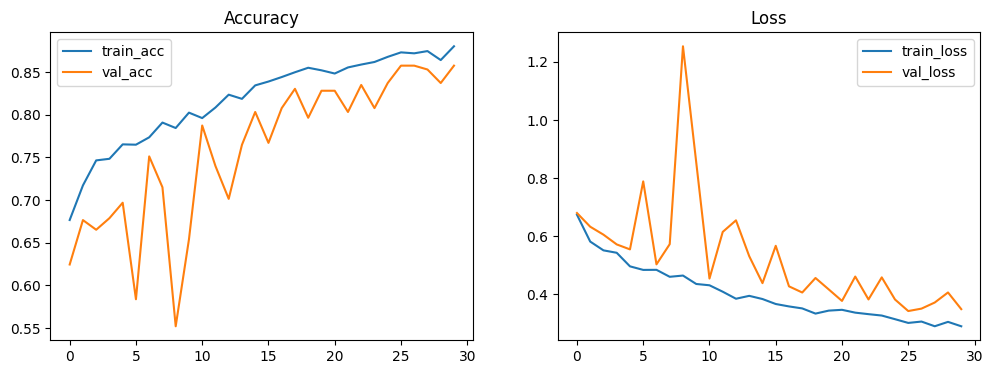

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load best weights (already restored by EarlyStopping, but ensure load)
custom_model.load_weights(checkpoint_path)

# Predict on test set
test_steps = test_gen.samples // test_gen.batch_size + (1 if test_gen.samples % test_gen.batch_size else 0)
preds = custom_model.predict(test_gen, steps=test_steps)
y_pred = (preds.flatten() >= 0.5).astype(int)
y_true = test_gen.classes[:len(y_pred)]

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# Plot training curves
def plot_history(h):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss')
    plt.show()

plot_history(history)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Robust model that accepts any HxW×3, resizes to 224×224, and applies EfficientNet preprocessing inside.
inp = keras.Input(shape=(None, None, 3), name="input_rgb")

x = layers.Resizing(224, 224, interpolation="bilinear", name="resize_224")(inp)
x = tf.keras.applications.efficientnet.preprocess_input(x)

base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_tensor=x
)
base.trainable = False  # start with frozen base

y = layers.GlobalAveragePooling2D()(base.output)
y = layers.Dense(256, activation="relu")(y)
y = layers.Dropout(0.4)(y)
out = layers.Dense(1, activation="sigmoid")(y)

transfer_model = keras.Model(inp, out, name="bird_drone_efficientnet_b0")

transfer_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
transfer_model.summary()

callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ModelCheckpoint("efficientb0_finetuned.keras", monitor="val_loss", save_best_only=True)
]

history_finetune = transfer_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "bird_drone_efficientnet_b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_rgb           │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_224          │ (None, 224, 224,  │          0 │ input_rgb[0][0]   │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ resize_224[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 2205s 26s/step - accuracy: 0.4953 - loss: 0.7246 - val_accuracy: 0.4910 - val_loss: 0.6989
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - accuracy: 0.5093 - loss: 0.7071 - val_accuracy: 0.4910 - val_loss: 0.6941
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.5389 - loss: 0.6919 - val_accuracy: 0.4910 - val_loss: 0.6943
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 0.5393 - loss: 0.6916 - val_accuracy: 0.4910 - val_loss: 0.6946
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - accuracy: 0.5312 - loss: 0.6921 - val_accuracy: 0.4910 - val_loss: 0.6952
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.5257 - loss: 0.6917 - val_accuracy: 0.4910 - val_loss: 0.6958
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.5308 - loss: 0.6930 - val_accuracy: 0.4910 - val_loss: 0.6955
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.5377 - loss: 0.6922 - val_accu

In [15]:
import tensorflow as tf
from tensorflow import keras

# your model is already built with:
# inp -> Resizing(224,224) -> tf.keras.applications.efficientnet.preprocess_input -> EfficientNetB0 -> head

# Save in native Keras format:
keras_path = "final_model_rgb224.keras"
model.save(keras_path, include_optimizer=False)

# Sanity-load right away:
m = keras.models.load_model(keras_path, compile=False)
print("Loaded shape:", m.input_shape)   # expect (None, None, None, 3)

# Optional: hash to verify later
import hashlib, os
def sha256(p, chunk=1<<20):
    h = hashlib.sha256()
    with open(p, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()
print("Size:", os.stat(keras_path).st_size, "bytes")
print("SHA256:", sha256(keras_path))


Loaded shape: (None, None, None, 3)
Size: 18357743 bytes
SHA256: 6d11d399d9c51956002eb0ad8ed3cb30aca4ecda257d0a22a669a3d2d4c2a667


In [16]:
import tensorflow as tf
print("TF:", tf.__version__)
try:
    import keras as k3
    print("Keras3:", k3.__version__)
except:
    from tensorflow import keras as tfk
    print("tf.keras:", tfk.__version__)

import numpy as np, h5py
print("NumPy:", np.__version__)
import h5py as _h5
print("h5py:", _h5.__version__)


TF: 2.19.0
Keras3: 3.10.0
NumPy: 2.0.2
h5py: 3.15.1


In [10]:
# Save a deployment-friendly model file for Streamlit
transfer_model.save("final_model.keras", include_optimizer=False)

# Optional: also export as SavedModel folder or H5 for maximum compatibility
# transfer_model.save("final_model_savedmodel", include_optimizer=False)
# transfer_model.save("final_model.h5", include_optimizer=False)


In [13]:
# after training and building with RGB + Resizing + preprocess inside the graph
transfer_model.save("final_model_rgb224.keras", include_optimizer=False)

# sanity check:
m = tf.keras.models.load_model("final_model_rgb224.keras", compile=False)
print("Loaded shape:", m.input_shape)  # should end with channels=3


Loaded shape: (None, None, None, 3)


In [11]:
loaded = tf.keras.models.load_model("final_model.keras", compile=False)
print("Loaded model input_shape:", loaded.input_shape)
# Should print something with 3 channels: (None, None, None, 3) or (None, 224, 224, 3)

Loaded model input_shape: (None, None, None, 3)


In [ ]:
checkpoint_tl = "/content/efficientb0_head.h5"
callbacks_tl = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_tl, monitor='val_loss', save_best_only=True)
]

history_tl = transfer_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks_tl
)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.5243 - loss: 0.7149

84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 945ms/step - accuracy: 0.5243 - loss: 0.7149 - val_accuracy: 0.4910 - val_loss: 0.6965
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 556ms/step - accuracy: 0.5135 - loss: 0.6975 - val_accuracy: 0.4910 - val_loss: 0.7017
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 542ms/step - accuracy: 0.5159 - loss: 0.6941 - val_accuracy: 0.4910 - val_loss: 0.7004
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5217 - loss: 0.6951

84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 570ms/step - accuracy: 0.5218 - loss: 0.6951 - val_accuracy: 0.4910 - val_loss: 0.6953
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 542ms/step - accuracy: 0.5097 - loss: 0.6947 - val_accuracy: 0.4910 - val_loss: 0.6956
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.5198 - loss: 0.6925

84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 567ms/step - accuracy: 0.5199 - loss: 0.6925 - val_accuracy: 0.4910 - val_loss: 0.6952
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.5297 - loss: 0.6924

84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 546ms/step - accuracy: 0.5297 - loss: 0.6924 - val_accuracy: 0.4910 - val_loss: 0.6949
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 558ms/step - accuracy: 0.5367 - loss: 0.6904 - val_accuracy: 0.4910 - val_loss: 0.6953
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.5313 - loss: 0.6912

84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 544ms/step - accuracy: 0.5313 - loss: 0.6912 - val_accuracy: 0.4910 - val_loss: 0.6945
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 551ms/step - accuracy: 0.5252 - loss: 0.6928 - val_accuracy: 0.4910 - val_loss: 0.6946


In [ ]:
# ✅ Unfreeze only the top EfficientNet layers for fine-tuning
import tensorflow as tf

# Unfreeze the whole model first
transfer_model.trainable = True

# Freeze the first N layers (lower-level feature extractors)
fine_tune_at = 200  # Adjust: try 150–250 depending on dataset size
for layer in transfer_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile with a smaller learning rate
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_finetune = transfer_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("/content/efficientb0_finetuned.h5", monitor='val_loss', save_best_only=True)
    ]
)



Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.5250 - loss: 0.6917

84/84 ━━━━━━━━━━━━━━━━━━━━ 89s 815ms/step - accuracy: 0.5251 - loss: 0.6917 - val_accuracy: 0.4910 - val_loss: 0.6945
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 546ms/step - accuracy: 0.5057 - loss: 0.6936 - val_accuracy: 0.4910 - val_loss: 0.6946
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 569ms/step - accuracy: 0.5378 - loss: 0.6908 - val_accuracy: 0.4910 - val_loss: 0.6946
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 568ms/step - accuracy: 0.5362 - loss: 0.6914 - val_accuracy: 0.4910 - val_loss: 0.6946
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 551ms/step - accuracy: 0.5380 - loss: 0.6912 - val_accuracy: 0.4910 - val_loss: 0.6946
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 552ms/step - accuracy: 0.5256 - loss: 0.6921 - val_accuracy: 0.4910 - val_loss: 0.6946
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 560ms/step - accuracy: 0.5335 - loss: 0.6917 - val_accuracy: 0.4910 - val_loss: 0.6946


In [ ]:
transfer_model.load_weights("/content/efficientb0_finetuned.h5")
preds_tl = transfer_model.predict(test_gen, steps=test_steps)
y_pred_tl = (preds_tl.flatten() >= 0.5).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_tl, target_names=list(train_gen.class_indices.keys())))
print("Confusion:\n", confusion_matrix(y_true, y_pred_tl))

7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
              precision    recall  f1-score   support

        bird       0.56      1.00      0.72       121
       drone       0.00      0.00      0.00        94

    accuracy                           0.56       215
   macro avg       0.28      0.50      0.36       215
weighted avg       0.32      0.56      0.41       215

Confusion:
 [[121   0]
 [ 94   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save Keras model and weights (if not already saved by checkpoints)
custom_model.save("/content/drive/MyDrive/aerial_project/custom_cnn_model.h5")
transfer_model.save("/content/drive/MyDrive/aerial_project/efficientb0_model.h5")
print("Saved models to Drive.")

Saved models to Drive.


In [ ]:
# Evaluate on test set
test_steps = test_gen.samples // test_gen.batch_size + (1 if test_gen.samples % test_gen.batch_size else 0)
preds_tl = transfer_model.predict(test_gen, steps=test_steps)

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
y_pred_tl = (preds_tl.flatten() >= 0.5).astype(int)
y_true = test_gen.classes[:len(y_pred_tl)]

print("✅ Classification Report:")
print(classification_report(y_true, y_pred_tl, target_names=list(train_gen.class_indices.keys())))

print("✅ Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_tl))


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 895ms/step
✅ Classification Report:
              precision    recall  f1-score   support

        bird       0.56      1.00      0.72       121
       drone       0.00      0.00      0.00        94

    accuracy                           0.56       215
   macro avg       0.28      0.50      0.36       215
weighted avg       0.32      0.56      0.41       215

✅ Confusion Matrix:
[[121   0]
 [ 94   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# If you already evaluated Custom CNN earlier, just print the metrics here.
print("Custom CNN Val Accuracy:", max(history.history['val_accuracy']))
print("EfficientNetB0 Val Accuracy:", max(history_tl.history['val_accuracy']))
print("Fine-tuned EfficientNetB0 Val Accuracy:", max(history_finetune.history['val_accuracy']))


Custom CNN Val Accuracy: 0.8574660420417786
EfficientNetB0 Val Accuracy: 0.49095022678375244
Fine-tuned EfficientNetB0 Val Accuracy: 0.49095022678375244


In [ ]:
# ✅ Use the new recommended format
best_model_path = "/content/drive/MyDrive/aerial_project/final_model.keras"
transfer_model.save(best_model_path)

print(f"✅ Model successfully saved to: {best_model_path}")



✅ Model successfully saved to: /content/drive/MyDrive/aerial_project/final_model.keras


In [ ]:
!pip install streamlit pyngrok

In [ ]:
# Run Streamlit app
!streamlit run /content/app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.247.128:8501

  Stopping...
  Stopping...


In [1]:
import os, json, math, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF:", tf.__version__)
print("Keras:", keras.__version__)

# Reproducibility-ish
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


TF: 2.19.0
Keras: 3.10.0


In [5]:

train_dir = os.path.join(BASE_PATH, "classification_dataset", "train")
val_dir   = os.path.join(BASE_PATH, "classification_dataset", "valid")
test_dir  = os.path.join(BASE_PATH, "classification_dataset", "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    # augmentations optional:
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest",
)
val_datagen = keras.preprocessing.image.ImageDataGenerator()
test_datagen = keras.preprocessing.image.ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, color_mode="rgb",
    batch_size=BATCH_SIZE, class_mode="binary", seed=SEED
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, color_mode="rgb",
    batch_size=BATCH_SIZE, class_mode="binary", shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, color_mode="rgb",
    batch_size=BATCH_SIZE, class_mode="binary", shuffle=False
)

print("Class indices:", train_gen.class_indices)  # EXPECT {'bird':0, 'drone':1}
with open("label_map.json", "w") as f:
    json.dump(train_gen.class_indices, f)


Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Class indices: {'bird': 0, 'drone': 1}


In [6]:
from collections import Counter

counts = Counter(train_gen.classes)   # 0 -> bird, 1 -> drone (if indices as above)
n0, n1 = counts.get(0, 0), counts.get(1, 0)
total = n0 + n1
# inverse frequency weighting
w0 = total / (2.0 * max(1, n0))
w1 = total / (2.0 * max(1, n1))
class_weight = {0: w0, 1: w1}
print("Class weights:", class_weight)


Class weights: {0: 0.9413012729844413, 1: 1.0665064102564104}


In [7]:
from tensorflow.keras.applications import efficientnet

keras.backend.clear_session()

inp = keras.Input(shape=(None, None, 3), name="input_rgb")

# Enforce your rule inside the graph too:
x = layers.Resizing(224, 224, interpolation="bilinear", name="resize_224")(inp)
x = efficientnet.preprocess_input(x)  # expects 0..255 and scales internally

base = efficientnet.EfficientNetB0(
    include_top=False, weights="imagenet", input_tensor=x
)
base.trainable = False  # freeze for warmup

y = layers.GlobalAveragePooling2D()(base.output)
y = layers.Dense(256, activation="relu")(y)
y = layers.Dropout(0.4)(y)
out = layers.Dense(1, activation="sigmoid")(y)

model = keras.Model(inp, out, name="bird_drone_efficientnet_b0")
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy", keras.metrics.AUC(name="auc")])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "bird_drone_efficientnet_b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_rgb           │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_224          │ (None, 224, 224,  │          0 │ input_rgb[0][0]   │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ resize_224[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
ckpt_path = "final_model_rgb224.keras"
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weight,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1362s 16s/step - accuracy: 0.9156 - auc: 0.9705 - loss: 0.1924 - val_accuracy: 0.9796 - val_auc: 0.9965 - val_loss: 0.0462
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 557ms/step - accuracy: 0.9936 - auc: 0.9998 - loss: 0.0226 - val_accuracy: 0.9819 - val_auc: 0.9963 - val_loss: 0.0515
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 529ms/step - accuracy: 0.9961 - auc: 0.9999 - loss: 0.0163 - val_accuracy: 0.9864 - val_auc: 0.9968 - val_loss: 0.0449
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 531ms/step - accuracy: 0.9965 - auc: 0.9999 - loss: 0.0109 - val_accuracy: 0.9774 - val_auc: 0.9989 - val_loss: 0.0427
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 530ms/step - accuracy: 0.9952 - auc: 0.9989 - loss: 0.0198 - val_accuracy: 0.9819 - val_auc: 0.9969 - val_loss: 0.0529
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 526ms/step - accuracy: 0.9993 - auc: 1.0000 - loss: 0.0061 - val_accuracy: 0.9864 - val_auc: 0.9970 - val_loss: 0.0493
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━

In [9]:
# Unfreeze the top of EfficientNetB0
for layer in base.layers[-40:]:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy", keras.metrics.AUC(name="auc")])

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 105s 877ms/step - accuracy: 0.9733 - auc: 0.9968 - loss: 0.0844 - val_accuracy: 0.9774 - val_auc: 0.9988 - val_loss: 0.0408
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 550ms/step - accuracy: 0.9845 - auc: 0.9992 - loss: 0.0455 - val_accuracy: 0.9842 - val_auc: 0.9989 - val_loss: 0.0408
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 535ms/step - accuracy: 0.9899 - auc: 0.9996 - loss: 0.0346 - val_accuracy: 0.9819 - val_auc: 0.9991 - val_loss: 0.0406
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 543ms/step - accuracy: 0.9901 - auc: 0.9998 - loss: 0.0289 - val_accuracy: 0.9819 - val_auc: 0.9991 - val_loss: 0.0400
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 533ms/step - accuracy: 0.9939 - auc: 0.9996 - loss: 0.0300 - val_accuracy: 0.9819 - val_auc: 0.9992 - val_loss: 0.0389
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 558ms/step - accuracy: 0.9876 - auc: 0.9996 - loss: 0.0328 - val_accuracy: 0.9842 - val_auc: 0.9992 - val_loss: 0.0382
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━

In [10]:
# Load best
best = keras.models.load_model(ckpt_path, compile=False)
print("Loaded model shape:", best.input_shape)   # (None, None, None, 3)

# Sanity prediction on zeros (matching the app’s input contract)
y0 = best.predict(np.zeros((1,224,224,3), dtype=np.float32), verbose=0)
print("Zero image score:", y0)


Loaded model shape: (None, None, None, 3)
Zero image score: [[0.511751]]


In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

# Collect scores on validation to choose threshold
val_scores = best.predict(val_gen, verbose=0).ravel()
val_true   = val_gen.classes
auc = roc_auc_score(val_true, val_scores)
fpr, tpr, thr = roc_curve(val_true, val_scores)
youden = np.argmax(tpr - fpr)
best_thr = float(thr[youden])
print(f"AUC={auc:.4f}, Youden threshold={best_thr:.4f}")

with open("inference_meta.json", "w") as f:
    json.dump({"threshold": best_thr}, f, indent=2)


AUC=0.9992, Youden threshold=0.5195
